# Text Emotion Labeler
## Bryce Hinkley
### UTSA Computer Science - Large Scale Database Management
### Spring 2023

This script is for creating a neural network that can be used to input text to assign one of 7 labels.

The seed is very important because if you have a different seed the one_hot can change and you will have a different type of result even when uploading the same model.

# Import libraries

In [1]:
import numpy as np
import pandas as pd 
import tensorflow as tf
import nltk
import seaborn as sns
import re
import matplotlib.pyplot as plt
import concurrent.futures
from IPython.display import clear_output
import os
import pickle


from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import random as rn

# Set the seed for numpy, tensorflow, and random
np.random.seed(0)
rn.seed(0)
tf.random.set_seed(0)

This is completely optional. I personally use it because I don't want to mount the Google Drive repeatedly and have the box pop up, plus it makes it easy to share the file with other people. So instead of needing the files on your Drive you should be able to download them that are publicly available on my Drive. Feel free to download onto a local machine them if you need them though.

In [2]:
!gdown --id 1udpdz9IyUAOgPbLzDmRnf17qI87tPpmd
!gdown --id 1goJShSS2bXxm6ExIKQXGLqIabUTzcSaA
# # https://drive.google.com/file/d/1goJShSS2bXxm6ExIKQXGLqIabUTzcSaA/view?usp=sharing

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1udpdz9IyUAOgPbLzDmRnf17qI87tPpmd
To: /content/emotion_final.csv
100% 2.26M/2.26M [00:00<00:00, 117MB/s]
/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1goJShSS2bXxm6ExIKQXGLqIabUTzcSaA
To: /content/glove.6B.100d.txt
100% 347M/347M [00:08<00:00, 42.4MB/s]


# Read and clean data

In [3]:
df=pd.read_csv('emotion_final.csv') #Text data
EMBEDDING_FILE= f'glove.6B.100d.txt' #GloVe file path
df.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


<Axes: xlabel='Emotion', ylabel='count'>

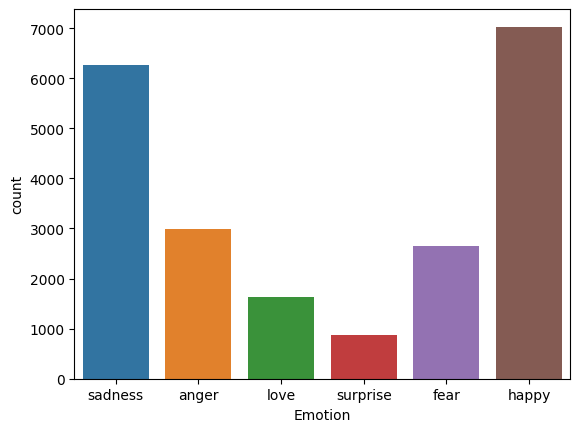

In [4]:
#Target Classes
sns.countplot(x = "Emotion", data = df)

In [5]:
df=df.dropna() #Drop columns with NA values
X=df.drop('Emotion',axis=1) #Input
y=df['Emotion'] #Output

In [6]:
messages=X.copy()
messages.reset_index(inplace=True) #Drop NA may cause inconsistency in index

In [7]:
nltk.download('stopwords')
ps = PorterStemmer()
corpus = []
for i in range(0, len(messages)):
    review = re.sub('[^a-zA-Z]', ' ', messages['Text'][i]) #Remove Special Characters
    review = review.lower() #Lower case 
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')] #Remove stopwords
    review = ' '.join(review)
    corpus.append(review)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
corpus[:10]

['didnt feel humili',
 'go feel hopeless damn hope around someon care awak',
 'im grab minut post feel greedi wrong',
 'ever feel nostalg fireplac know still properti',
 'feel grouchi',
 'ive feel littl burden late wasnt sure',
 'ive take milligram time recommend amount ive fallen asleep lot faster also feel like funni',
 'feel confus life teenag jade year old man',
 'petrona year feel petrona perform well made huge profit',
 'feel romant']

# Embedding layer using GloVe 

In [9]:
#Creating the dictionary with word as key and pretrained-value array as value
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE))

#Calculate mean and std for the pretrained weights
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
print(emb_mean,emb_std)

/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


0.004451992 0.4081574


In [10]:
voc_size=10000 # Vocabulary size
embed_size=100 #word vector size

tokenizer = Tokenizer(num_words=voc_size)
tokenizer.fit_on_texts(list(corpus))
word_index = tokenizer.word_index #Total words in the corpus
nb_words = min(voc_size, len(word_index))

#Initialize weight matrix for embedding layer
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size)) 

for word, i in word_index.items():
    if i >= voc_size: continue #Skip the words if vocab size is reached
    embedding_vector = embeddings_index.get(word) #Extract the pretrained values from GloVe
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector
np.save('embedding_matrix.npy', embedding_matrix)


In [11]:
#Contains the pretrained GloVe weights for the words
len(embedding_matrix)

10000

# Process Input-Output data

In [12]:
#One hot representation for input
onehot_repr=[one_hot(words,voc_size)for words in corpus]
with open('onehot_repr.pkl', 'wb') as f:
    pickle.dump(onehot_repr, f)
#Finding max words
l = 0
for x in corpus:
    l = max(l,len(x.split(' ')))

#Padding the sequences for input
sent_length= l
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[   0    0    0 ... 2557  166 9077]
 [   0    0    0 ... 3127 2347 6978]
 [   0    0    0 ...  166 4459 3226]
 ...
 [   0    0    0 ... 1549 9268 2697]
 [   0    0    0 ... 3824 2697 8012]
 [   0    0    0 ...    0 2697 4343]]


In [13]:
#Encoding the target outputs to integers
label_encoder = preprocessing.LabelEncoder()

X_final=np.array(embedded_docs) #input to array
y = label_encoder.fit_transform(y)
y_final=np.array(y)
print(y_final)
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)


[4 4 0 ... 1 1 1]


In [14]:
X_final.shape,y_final.shape

((21459, 35), (21459,))

In [15]:
#Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, 
                                                    test_size=0.2, random_state=42) 
#Train-Validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.1, random_state=21) 

# Create and train model

In [16]:
# Creating model
model=Sequential()
model.add(Embedding(voc_size, embed_size, weights=[embedding_matrix]))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l1(0.01))) #L1 regularization
model.add(Dropout(0.3))
model.add(Dense(6,activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         1000000   
                                                                 
 dropout (Dropout)           (None, None, 100)         0         
                                                                 
 bidirectional (Bidirectiona  (None, 128)              84480     
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                        

In [17]:
!pip install pydot graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


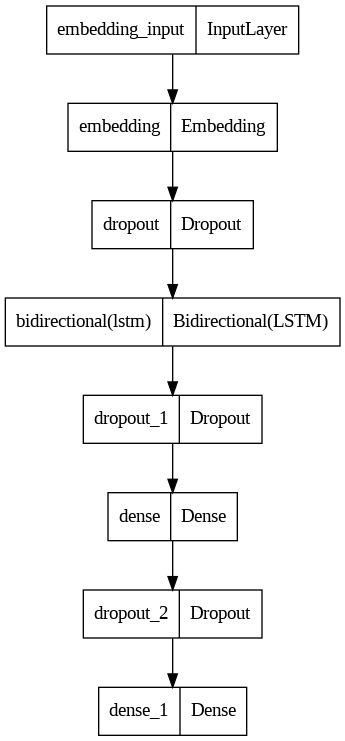

In [18]:
tf.keras.utils.plot_model(model, show_shapes=False, 
                          show_layer_names=True, rankdir='TB',
                          expand_nested=False, dpi=96)

In [19]:
model_save = ModelCheckpoint('weights.h5', save_best_only = True, save_weights_only = True, monitor = 'val_loss', 
                             mode = 'min', verbose = 1)
history = model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=50,batch_size=30,callbacks = [model_save])

Epoch 1/20
515/515 [==============================] - ETA: 0s - loss: 2.6251 - accuracy: 0.3213
Epoch 1: val_loss improved from inf to 1.64424, saving model to weights.h5
515/515 [==============================] - 17s 25ms/step - loss: 2.6251 - accuracy: 0.3213 - val_loss: 1.6442 - val_accuracy: 0.3151
Epoch 2/20
514/515 [============================>.] - ETA: 0s - loss: 1.6200 - accuracy: 0.3241
Epoch 2: val_loss improved from 1.64424 to 1.62415, saving model to weights.h5
515/515 [==============================] - 11s 22ms/step - loss: 1.6200 - accuracy: 0.3241 - val_loss: 1.6242 - val_accuracy: 0.3151
Epoch 3/20
514/515 [============================>.] - ETA: 0s - loss: 1.6081 - accuracy: 0.3285
Epoch 3: val_loss improved from 1.62415 to 1.61839, saving model to weights.h5
515/515 [==============================] - 11s 22ms/step - loss: 1.6081 - accuracy: 0.3287 - val_loss: 1.6184 - val_accuracy: 0.3151
Epoch 4/20
514/515 [============================>.] - ETA: 0s - loss: 1.6055 - a

# Analysis and visualization of output

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


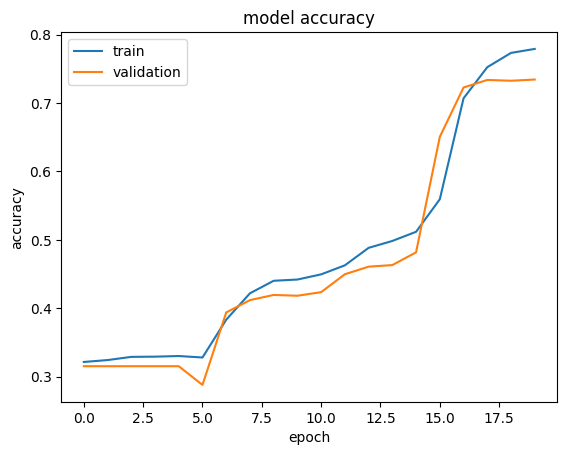

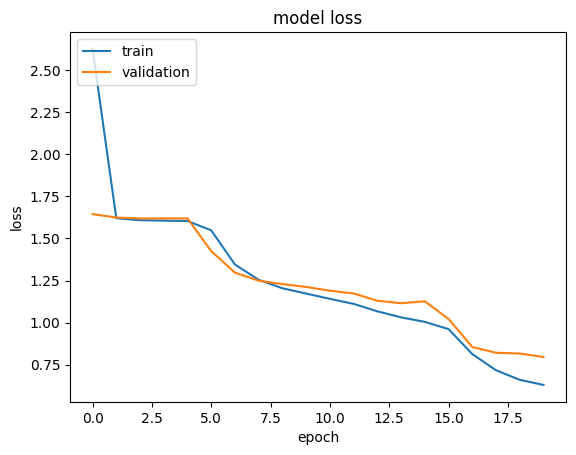

In [20]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [21]:
#Load the best weights
model.load_weights('weights.h5')

In [22]:
# get predicted probabilities for each class
y_pred_prob = model.predict(X_test)

# get the class indices of the highest probability
y_pred = np.argmax(y_pred_prob, axis=1)

135/135 [==============================] - 2s 7ms/step


In [23]:
#Accuracy score
print(accuracy_score(y_test,y_pred))

0.7483690587138863


In [24]:
#Classification report
print(classification_report(y_test, y_pred, digits=5))

              precision    recall  f1-score   support

           0    0.43122   0.90438   0.58399       617
           1    0.00000   0.00000   0.00000       531
           2    0.91416   0.87907   0.89627      1381
           3    0.72464   0.78616   0.75415       318
           4    0.89811   0.93187   0.91468      1277
           5    0.00000   0.00000   0.00000       168

    accuracy                        0.74837      4292
   macro avg    0.49469   0.58358   0.52485      4292
weighted avg    0.67704   0.74837   0.70036      4292



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix
Axes(0.125,0.11;0.62x0.77)


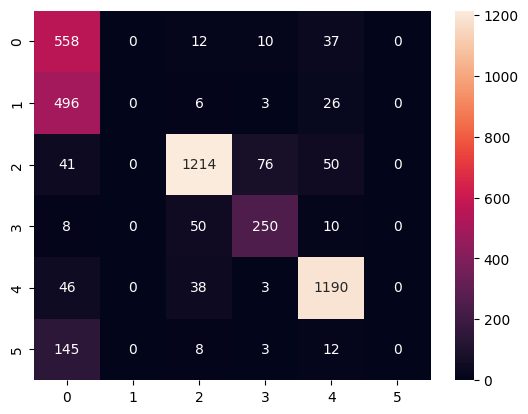

In [25]:
#Confusion Matrix
print('Confusion Matrix')
print(sns.heatmap(confusion_matrix(y_test, y_pred),annot=True,fmt="d"))

# Test on own

In [83]:
#Mapping of target classes using label-encoder
le_name_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(le_name_mapping)

{'anger': 0, 'fear': 1, 'happy': 2, 'love': 3, 'sadness': 4, 'surprise': 5}


In [86]:
#Example
def predict_emotion(stri):
    review = re.sub('[^a-zA-Z]', ' ', stri)
    review = review.lower()
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    # print(review)
    onehot_repr = [one_hot(review,voc_size)] 
    # print(onehot_repr)
    embed = pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
    # print(embed)
    predicti = model.predict(embed)
    # print(predicti)
    return label_encoder.classes_[np.argmax(predicti)]

In [87]:
predict_emotion('I am very happy today')

happi today
[[2492, 5791]]
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0 2492 5791]]
1/1 [==============================] - 0s 26ms/step
[[0.14348501 0.12426582 0.32340613 0.07797647 0.28918532 0.04168118]]


'happy'

In [32]:
predict_emotion('He is an arrogant and rude person')

1/1 [==============================] - 0s 28ms/step


0

In [33]:
predict_emotion('ALL THAT SWEET KARMA!')

1/1 [==============================] - 0s 26ms/step


1

In [56]:
predict_emotion('Hello')

hello
[[459]]
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 459]]
1/1 [==============================] - 0s 28ms/step
[[0.11390027 0.6156983  0.09245743 0.01362353 0.08100274 0.08331777]]


1

In [26]:
model.save('my_model')

In [27]:
import shutil
shutil.make_archive('my_model', 'zip', 'my_model')


'/content/my_model.zip'

# Load MySQL Data

In [ ]:
# !pip install mysql-connector-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# import mysql.connector

In [ ]:
# mydb = mysql.connector.connect(
#   host="ls-EXAMPLE",
#   user="EXAMPLE",
#   password="EXAMPLE",
#   database="EXAMPLE"
# )

# try:
#     query = "Select body from EXAMPLE;"
#     result_dataFrame = pd.read_sql(query,mydb)
#     mydb.close() #close the connection
#     print(result_dataFrame.head())
# except Exception as e:
#     mydb.close()
#     print(str(e))

<ipython-input-8-cadb878b7c6a>:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result_dataFrame = pd.read_sql(query,mydb)


In [ ]:
# result_dataFrame['labels']=result_dataFrame['body'].apply(predict)